In [41]:
library(forecast)
library(caret)
library(glmnet)
library(data.table)
library(fpp2)
library(skimr)
library(ggcorrplot)
library(zoo)
library(lubridate)
library(urca)
library(rpart)
library(rattle)
require(treeClust)

In [42]:
path="C:/Users/alpsr/Desktop/IE 48B Project/Codes/"
#options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)
options(warn=-1)
bulk_imbalance = fread(sprintf("%sbulk_imbalance.csv", path))
data = bulk_imbalance
data = data[order(date,hour)]
data[,ID := 1:.N]
str(data)

Classes 'data.table' and 'data.frame':	26832 obs. of  13 variables:
 $ date                   : IDate, format: "2019-01-01" "2019-01-01" ...
 $ hour                   : int  0 1 2 3 4 5 6 7 8 9 ...
 $ net                    : num  -1935 -751 -983 -765 -1233 ...
 $ upRegulationZeroCoded  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ upRegulationOneCoded   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ upRegulationTwoCoded   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ downRegulationZeroCoded: num  2289 808 1061 1120 1875 ...
 $ downRegulationOneCoded : num  0 0 0 0 56 56 0 0 0 0 ...
 $ downRegulationTwoCoded : int  0 0 0 0 0 0 0 0 0 0 ...
 $ upRegulationDelivered  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ downRegulationDelivered: num  -1935 -751 -983 -765 -1233 ...
 $ system_direction       : chr  "Negative" "Negative" "Negative" "Negative" ...
 $ ID                     : int  1 2 3 4 5 6 7 8 9 10 ...
 - attr(*, ".internal.selfref")=<externalptr> 


## Data Analysis

In [43]:
head(data, 128)

date,hour,net,upRegulationZeroCoded,upRegulationOneCoded,upRegulationTwoCoded,downRegulationZeroCoded,downRegulationOneCoded,downRegulationTwoCoded,upRegulationDelivered,downRegulationDelivered,system_direction,ID
<date>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<int>
2019-01-01,0,-1934.795,0.000,0,0,2288.567,0,0,0.000,-1934.795,Negative,1
2019-01-01,1,-750.866,0.000,0,0,808.083,0,0,0.000,-750.866,Negative,2
2019-01-01,2,-982.767,0.000,0,0,1060.750,0,0,0.000,-982.767,Negative,3
2019-01-01,3,-764.620,0.000,0,0,1120.483,0,0,0.000,-764.620,Negative,4
2019-01-01,4,-1233.289,0.000,0,0,1874.633,56,0,0.000,-1233.289,Negative,5
2019-01-01,5,-1469.061,0.000,0,0,2125.000,56,0,0.000,-1469.061,Negative,6
2019-01-01,6,-1444.749,0.000,0,0,2086.000,0,0,0.000,-1444.749,Negative,7
2019-01-01,7,-1339.938,0.000,0,0,1963.000,0,0,0.000,-1339.938,Negative,8
2019-01-01,8,-1884.543,0.000,0,0,2509.767,0,0,0.000,-1884.543,Negative,9


In [44]:
skim(data)

-- Data Summary ------------------------
                           Values
Name                       data  
Number of rows             26832 
Number of columns          13    
Key                        NULL  
_______________________          
Column type frequency:           
  character                1     
  Date                     1     
  numeric                  11    
________________________         
Group variables            None  

-- Variable type: character ----------------------------------------------------
# A tibble: 1 x 8
  skim_variable    n_missing complete_rate   min   max empty n_unique whitespace
* <chr>                <int>         <dbl> <int> <int> <int>    <int>      <int>
1 system_direction         0             1     0     8    24        4          0

-- Variable type: Date ---------------------------------------------------------
# A tibble: 1 x 7
  skim_variable n_missing complete_rate min        max        median    
* <chr>             <int>         <

In [45]:
# completing the missing values in the net columns
data[,net := na.aggregate(net,by=.(hour,wday(date)))]

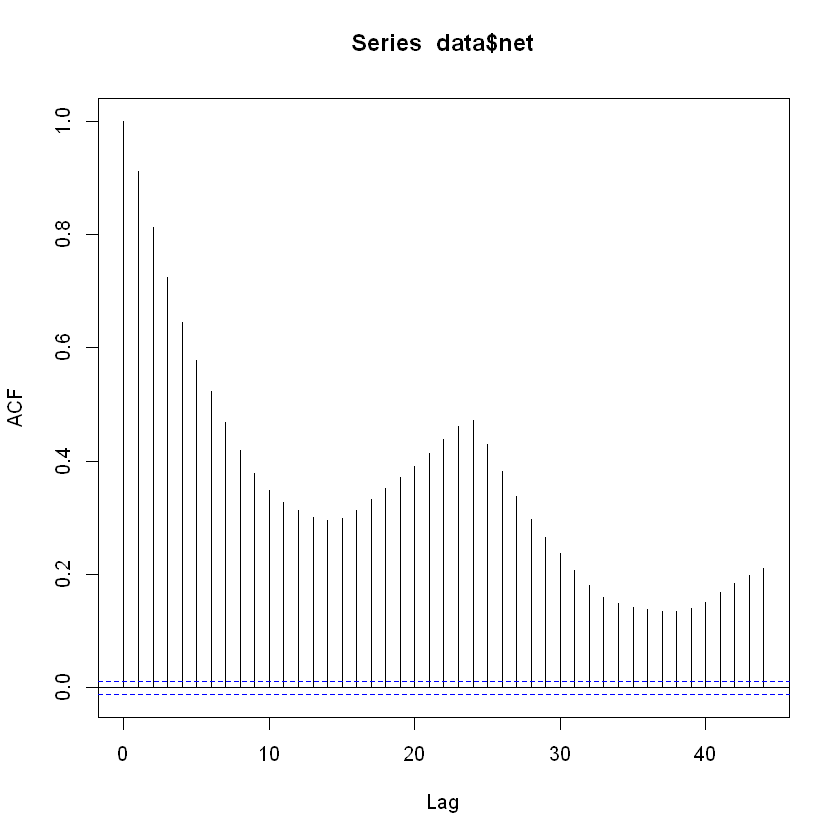

In [46]:
# checking the autocorrelations
acf(data$net)

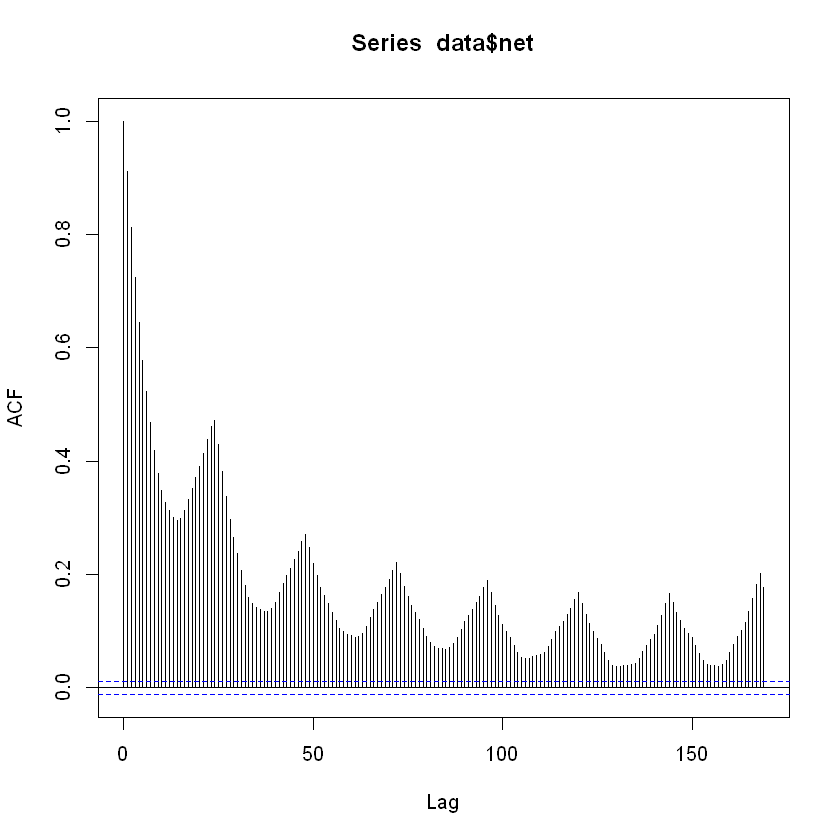

In [47]:
acf <- acf(data$net,lag.max = 169)

In [48]:
# creating the lagged variables, we will not have access to lag6, lag7, and lag8 values while submitting our predictions
data[, lag_24:=shift(net, 24)]
data[, lag_168:=shift(net, 168)]
data[, lag_6:=shift(net, 6)]
data[, lag_7:=shift(net, 7)]
data[, lag_8:=shift(net, 8)]
data <- data[seq(-168,-1),]

In [49]:
# creating binary variables for the day of the week
data$weekday=wday(data$date)
data[, is_monday:=ifelse(weekday==2, 1, 0)]
data[, is_wday:=ifelse(weekday%in%c(3,4,5), 1, 0)]
data[, is_friday:=ifelse(weekday==6, 1, 0)]
data[, is_saturday:=ifelse(weekday==7, 1, 0)]
data[, is_sunday:=ifelse(weekday==1, 1, 0)]

In [50]:
# creating binary variables for the hour of the day
data[, is_over:=ifelse(hour%in% c(17,18,19,20) , 1, 0)]
data[, is_12:=ifelse(hour==12 , 1, 0)]
data[, is_13:=ifelse(hour==13 , 1, 0)]
data[, is_22:=ifelse(hour==22 , 1, 0)]
data[, is_23:=ifelse(hour==23 , 1, 0)]

In [51]:
# removing outliers from the dataset
# outliers := 0.025 quantile on the both sides
upper_limit=quantile(data$net, 0.975)
lower_limit=quantile(data$net, 0.025)
data[, is_outlier:=ifelse((net<=upper_limit) &  (net>=lower_limit), 0, 1)]
data[, net_shift:=shift(net, 168)]
data[is_outlier==1, net:=net_shift]
data$net_shift=NULL
data$is_outlier=NULL

In [52]:
data[,net := na.aggregate(net,by=.(hour,wday(date)))]

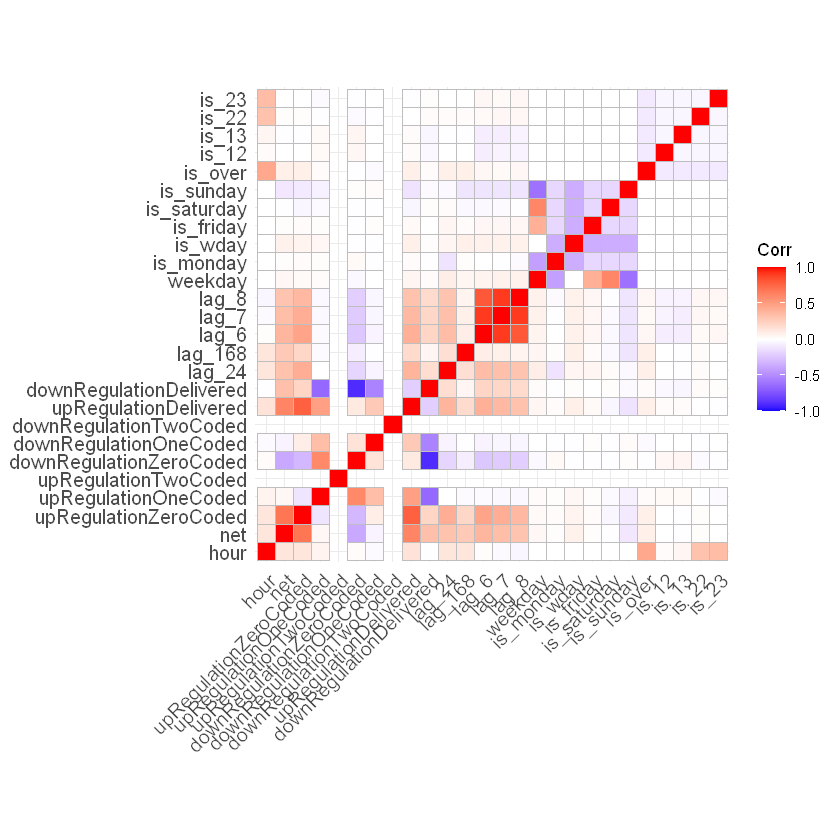

In [53]:
corr <- cor(data[,-c('date','ID', 'system_direction')])
ggcorrplot(corr)

# Weather Dataset

In [54]:
features = fread(sprintf("%s2022-01-22_weather.csv", path))

wide_feat = dcast(features, date + hour ~ variable+ lat + lon , value.var="value")
#tail(wide_feat)
#colnames(wide_feat)

In [55]:
mod_cols <- colnames(wide_feat)[c(-1,-2)]

wide_feat[ , (mod_cols) := lapply(.SD,na.aggregate, by=.(hour,wday(date))), .SDcols = mod_cols]
wide_feat[ , hour := as.factor(hour)]
#wide_feat[,net := na.aggregate(net,by=.(hour,wday(date)))]

head(wide_feat)

date,hour,DSWRF_surface_36.5_32.5,DSWRF_surface_37_35.5,DSWRF_surface_38_32.5,DSWRF_surface_38.5_27,DSWRF_surface_39.75_30.5,DSWRF_surface_40_33,DSWRF_surface_41_28.75,RH_2.m.above.ground_36.5_32.5,...,wdir_10m_39.75_30.5,wdir_10m_40_33,wdir_10m_41_28.75,ws_10m_36.5_32.5,ws_10m_37_35.5,ws_10m_38_32.5,ws_10m_38.5_27,ws_10m_39.75_30.5,ws_10m_40_33,ws_10m_41_28.75
<date>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-12-31,0,0,0,0,0,0,0,0,83.30000,...,336.5883,93.47636,288.4040,2.790017,2.355400,0.8009606,2.684959,0.7788009,0.9122336,3.150579
2018-12-31,1,0,0,0,0,0,0,0,82.00000,...,341.7422,90.29830,296.8295,2.725563,2.309428,0.6506007,2.672927,1.0005702,0.8931703,3.118881
2018-12-31,2,0,0,0,0,0,0,0,80.70000,...,346.8962,87.12025,305.2550,2.661109,2.263456,0.5002407,2.660895,1.2223395,0.8741070,3.087182
2018-12-31,3,0,0,0,0,0,0,0,79.40000,...,352.0501,83.94219,313.6806,2.596655,2.217484,0.3498807,2.648862,1.4441088,0.8550436,3.055483
2018-12-31,4,0,0,0,0,0,0,0,78.83333,...,349.8105,93.91665,308.5280,2.551815,2.207310,0.3796237,2.636125,1.5497829,0.7646836,2.920705
2018-12-31,5,0,0,0,0,0,0,0,78.26667,...,347.5710,103.89111,303.3753,2.506976,2.197135,0.4093667,2.623388,1.6554570,0.6743235,2.785928


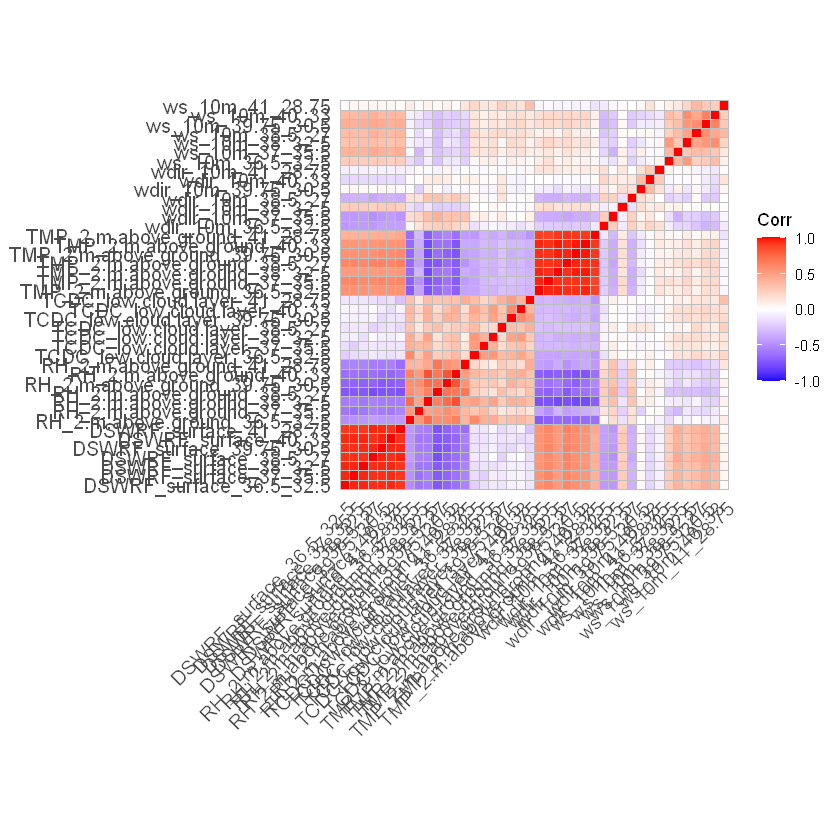

In [56]:
corr <- cor(wide_feat[,-c('date', 'hour')])
ggcorrplot(corr)

# Train-Test

In [57]:
data[,hour_num := hour]
data[,hour := as.factor(hour)]
train = data[date <= "2021-11-30",]
test = data[date >= "2021-12-01" & date <= "2021-12-14",]

In [58]:
tail(train,24)

date,hour,net,upRegulationZeroCoded,upRegulationOneCoded,upRegulationTwoCoded,downRegulationZeroCoded,downRegulationOneCoded,downRegulationTwoCoded,upRegulationDelivered,...,is_wday,is_friday,is_saturday,is_sunday,is_over,is_12,is_13,is_22,is_23,hour_num
<date>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2021-11-30,0,-414.417,0.000,0,0,414.417,0.000,0,0.000,...,1,0,0,0,0,0,0,0,0,0
2021-11-30,1,-28.266,77.334,0,0,108.600,0.000,0,77.334,...,1,0,0,0,0,0,0,0,0,1
2021-11-30,2,-81.666,0.000,0,0,0.000,81.666,0,0.000,...,1,0,0,0,0,0,0,0,0,2
2021-11-30,3,19.440,140.333,0,0,0.000,100.000,0,119.440,...,1,0,0,0,0,0,0,0,0,3
2021-11-30,4,-67.567,37.100,0,0,0.000,100.000,0,32.433,...,1,0,0,0,0,0,0,0,0,4
2021-11-30,5,-297.689,0.000,0,0,109.083,236.000,0,0.000,...,1,0,0,0,0,0,0,0,0,5
2021-11-30,6,545.407,971.100,0,0,0.000,355.334,0,894.351,...,1,0,0,0,0,0,0,0,0,6
2021-11-30,7,1259.204,1534.600,0,0,8.200,133.299,0,1357.146,...,1,0,0,0,0,0,0,0,0,7
2021-11-30,8,246.265,1085.884,0,0,224.600,434.233,0,879.311,...,1,0,0,0,0,0,0,0,0,8


In [59]:
train_feat <- wide_feat[date <= "2021-11-30",]
test_feat <- wide_feat[date >= "2021-12-01" & date <= "2021-12-14",]

train <- merge(train, train_feat, by.x = c("date","hour"),by.y = c("date","hour"))
test <- merge(test, test_feat, by.x = c("date","hour"), by.y = c("date","hour"))

# PCA Analysis for the Weather Data

In [60]:
pca_rep_dswrf = princomp(train[,c(31:37)])
summary(pca_rep_dswrf) # one column covers 95%. One component added to the dataset

train[,DSWRF:=pca_rep_dswrf$scores[,1]]
test[, DSWRF := predict(pca_rep_dswrf,test)[,1]]

Importance of components:
                            Comp.1      Comp.2       Comp.3       Comp.4
Standard deviation     710.1498613 93.22739097 71.769088202 56.962950687
Proportion of Variance   0.9530801  0.01642542  0.009734289  0.006132172
Cumulative Proportion    0.9530801  0.96950547  0.979239757  0.985371929
                             Comp.5       Comp.6       Comp.7
Standard deviation     52.644834487 51.406081519 48.231054017
Proportion of Variance  0.005237703  0.004994113  0.004396255
Cumulative Proportion   0.990609632  0.995603745  1.000000000

In [61]:
pca_rep_rh = princomp(train[,c(38:44)])
summary(pca_rep_rh) #three components cover 87% of the variance. Three components added to the data set.

train[,RH1 := pca_rep_rh$scores[,1]]
test[, RH1 := predict(pca_rep_rh,test)[,1]]

train[,RH2 := pca_rep_rh$scores[,2]]
test[, RH2 := predict(pca_rep_rh,test)[,2]]

train[,RH3 := pca_rep_rh$scores[,3]]
test[, RH3 := predict(pca_rep_rh,test)[,3]]

Importance of components:
                           Comp.1     Comp.2      Comp.3      Comp.4     Comp.5
Standard deviation     44.1002159 17.3773147 15.92128914 12.98898049 9.42582646
Proportion of Variance  0.6763797  0.1050206  0.08815878  0.05867583 0.03089925
Cumulative Proportion   0.6763797  0.7814003  0.86955905  0.92823488 0.95913413
                           Comp.6     Comp.7
Standard deviation     7.80862542 7.51858275
Proportion of Variance 0.02120598 0.01965989
Cumulative Proportion  0.98034011 1.00000000

In [62]:
pca_rep_tcdc = princomp(train[,c(45:51)])
summary(pca_rep_tcdc) #three components cover 74% of the variance. Three components added to the data set.

train[,tcdc1 := pca_rep_tcdc$scores[,1]]
test[, tcdc1 := predict(pca_rep_tcdc,test)[,1]]

train[,tcdc2 := pca_rep_tcdc$scores[,2]]
test[, tcdc2 := predict(pca_rep_tcdc,test)[,2]]

train[,tcdc3 := pca_rep_tcdc$scores[,3]]
test[, tcdc3 := predict(pca_rep_tcdc,test)[,3]]

Importance of components:
                           Comp.1     Comp.2     Comp.3      Comp.4      Comp.5
Standard deviation     54.6921538 31.9188681 26.3156744 21.67549597 21.05297674
Proportion of Variance  0.4712219  0.1604983  0.1090949  0.07401393  0.06982363
Cumulative Proportion   0.4712219  0.6317202  0.7408151  0.81482899  0.88465262
                            Comp.6     Comp.7
Standard deviation     20.15768068 18.0519336
Proportion of Variance  0.06401128  0.0513361
Cumulative Proportion   0.94866390  1.0000000

In [63]:
pca_rep_tmp = princomp(train[,c(52:58)])
summary(pca_rep_tmp) #one component cover 95% of the variance. One component added to the data set.

train[,tmp := pca_rep_tmp$scores[,1]]
test[, tmp := predict(pca_rep_tmp,test)[,1]]

Importance of components:
                           Comp.1     Comp.2     Comp.3      Comp.4      Comp.5
Standard deviation     21.9908384 2.96244343 2.50179386 2.142137342 1.686969399
Proportion of Variance  0.9500318 0.01724069 0.01229582 0.009014657 0.005590736
Cumulative Proportion   0.9500318 0.96727249 0.97956831 0.988582967 0.994173703
                            Comp.6      Comp.7
Standard deviation     1.371608343 1.041376392
Proportion of Variance 0.003695854 0.002130444
Cumulative Proportion  0.997869556 1.000000000

In [64]:
pca_rep_wdir = princomp(train[,c(59:65)])
summary(pca_rep_wdir) # results are not great. no components are added.

#train[,wdir := pca_rep_wdir$scores[,1]]
#test[, wdir := predict(pca_rep_wdir,test)[,1]]

Importance of components:
                            Comp.1      Comp.2     Comp.3     Comp.4     Comp.5
Standard deviation     129.3206610 111.0099164 91.7778770 83.8435610 80.9109586
Proportion of Variance   0.2723321   0.2006719  0.1371637  0.1144728  0.1066050
Cumulative Proportion    0.2723321   0.4730040  0.6101677  0.7246405  0.8312456
                           Comp.6      Comp.7
Standard deviation     75.1963733 68.61970175
Proportion of Variance  0.0920782  0.07667622
Cumulative Proportion   0.9233238  1.00000000

In [65]:
pca_rep_wda = princomp(train[,c(66:72)])
summary(pca_rep_wda) #three components cover 74% of the variance. Three components added to the data set.

train[,wda1 := pca_rep_wda$scores[,1]]
test[, wda1 := predict(pca_rep_wda,test)[,1]]

train[,wda2 := pca_rep_wda$scores[,2]]
test[, wda2 := predict(pca_rep_wda,test)[,2]]

train[,wda3 := pca_rep_wda$scores[,3]]
test[, wda3 := predict(pca_rep_wda,test)[,3]]

Importance of components:
                         Comp.1    Comp.2     Comp.3     Comp.4     Comp.5
Standard deviation     3.764560 2.2219678 1.70487559 1.69165770 1.45690721
Proportion of Variance 0.480093 0.1672524 0.09846509 0.09694421 0.07190526
Cumulative Proportion  0.480093 0.6473454 0.74581047 0.84275468 0.91465994
                           Comp.6     Comp.7
Standard deviation     1.14834336 1.09565930
Proportion of Variance 0.04467252 0.04066754
Cumulative Proportion  0.95933246 1.00000000

# First Model

In [66]:
getModelInfo("rpart2")

parameter,class,label
<chr>,<chr>,<chr>
maxdepth,numeric,Max Tree Depth


In [67]:
ctrl = trainControl(method="repeatedcv",repeats = 3,number=10) 
#colnames(train)

In [ ]:
training = train[hour_num >= 12,c("system_direction", "lag_24", "lag_168", "is_monday", "is_wday", "is_friday", "is_saturday",
                    "is_sunday","is_over","is_12","is_13","is_22","is_23","wdir_10m_36.5_32.5", "wdir_10m_37_35.5", "wdir_10m_38_32.5",
                    "wdir_10m_38.5_27", "wdir_10m_39.75_30.5", "wdir_10m_40_33", "wdir_10m_41_28.75",
                    "DSWRF","RH1","RH2","tcdc1","tcdc2","RH3","tcdc3","tmp","wda1","wda2","wda3")]
trainclass = training$system_direction

testing = test[hour_num >= 12,c("system_direction", "lag_24", "lag_168", "is_monday", "is_wday", "is_friday", "is_saturday",
                    "is_sunday","is_over","is_12","is_13","is_22","is_23","wdir_10m_36.5_32.5", "wdir_10m_37_35.5", "wdir_10m_38_32.5",
                    "wdir_10m_38.5_27", "wdir_10m_39.75_30.5", "wdir_10m_40_33", "wdir_10m_41_28.75",
                    "DSWRF","RH1","RH2","tcdc1","tcdc2","RH3","tcdc3","tmp","wda1","wda2","wda3")]
testclass=testing$system_direction

In [99]:
head(training)

system_direction,lag_24,lag_168,is_monday,is_wday,is_friday,is_saturday,is_sunday,is_over,is_12,...,RH1,RH2,tcdc1,tcdc2,RH3,tcdc3,tmp,wda1,wda2,wda3
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Positive,1776.793,-855.563,0,1,0,0,0,0,1,...,64.98641,14.40467,112.6433,90.21472,22.07857,26.44315,-40.98967,5.483698,-1.7343250,0.7333573
Positive,1824.072,-78.651,0,1,0,0,0,0,0,...,61.77710,14.58712,112.7087,88.64714,22.13005,27.84654,-40.61661,5.443663,-1.2081201,1.1914301
Positive,1948.549,202.696,0,1,0,0,0,0,0,...,58.56779,14.76957,112.7740,87.07956,22.18152,29.24994,-40.24356,5.403628,-0.6819152,1.6495029
Positive,2024.501,206.927,0,1,0,0,0,0,0,...,55.35848,14.95202,112.8393,85.51197,22.23300,30.65334,-39.87050,5.363594,-0.1557103,2.1075757
Positive,2276.499,-564.851,0,1,0,0,0,0,0,...,58.76211,13.86456,124.0065,66.50417,20.63367,40.55371,-41.15042,4.495786,0.1531923,2.0008056
Positive,1628.765,-1067.564,0,1,0,0,0,1,0,...,62.16574,12.77710,135.1737,47.49636,19.03435,50.45407,-42.43034,3.627978,0.4620949,1.8940355


In [100]:
model1 <- train(
            system_direction ~ .,
            data = training,
            method = "rpart2",
            trControl = ctrl,
            tuneLength = 5)

In [101]:
model1

CART 

12696 samples
   30 predictor
    3 classes: 'Negative', 'Neutral', 'Positive' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 11426, 11427, 11427, 11427, 11427, 11427, ... 
Resampling results across tuning parameters:

  maxdepth  Accuracy   Kappa    
  1         0.6050208  0.1870097
  2         0.6116108  0.1184808
  6         0.6110588  0.1454270
  7         0.6110588  0.1454270
  8         0.6110588  0.1454270

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was maxdepth = 2.

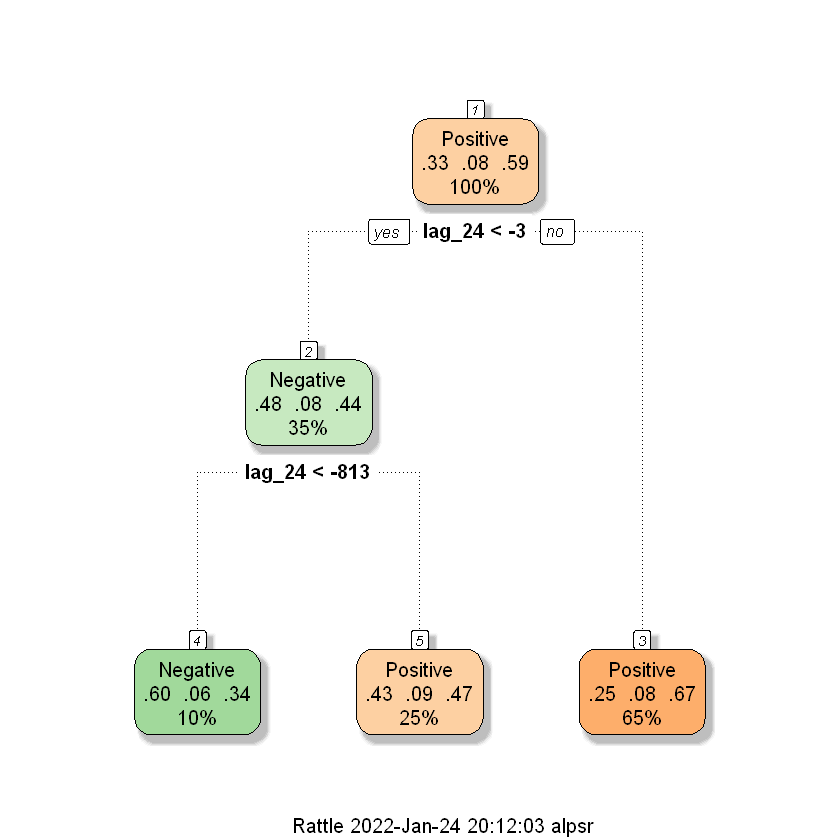

In [121]:
dec_tree1 = rpart(system_direction ~ .,training,method='class',control=rpart.control(cp=0,maxdepth=2))
fancyRpartPlot(dec_tree1)

In [122]:
train_fit = predict(dec_tree1,training)
train_pred = data.table(train_fit)
train_pred_label = colnames(train_pred)[apply(train_pred,1,which.max)]

In [123]:
table(train_pred_label,trainclass)
print(sum(train_pred_label == trainclass)/length(trainclass))

                trainclass
train_pred_label Negative Neutral Positive
        Negative      771      79      434
        Positive     3468     925     7019

[1] 0.6135791


In [125]:
confusionMatrix(data = as.factor(train_pred_label), reference = as.factor(trainclass), mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction Negative Neutral Positive
  Negative      771      79      434
  Neutral         0       0        0
  Positive     3468     925     7019

Overall Statistics
                                         
               Accuracy : 0.6136         
                 95% CI : (0.605, 0.6221)
    No Information Rate : 0.587          
    P-Value [Acc > NIR] : 5.797e-10      
                                         
                  Kappa : 0.1189         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      

Statistics by Class:

                     Class: Negative Class: Neutral Class: Positive
Precision                    0.60047             NA          0.6151
Recall                       0.18188        0.00000          0.9418
F1                           0.27920             NA          0.7441
Prevalence                   0.33388        0.07908          0.5870
Detection Rate               0.06073  

In [105]:
test_fit = predict(dec_tree1,testing)
test_pred = data.table(test_fit)
test_pred_label = colnames(test_pred)[apply(test_pred,1,which.max)]

In [107]:
table(test_pred_label,testclass)
print(sum(test_pred_label == testclass)/length(testclass))

               testclass
test_pred_label Negative Neutral Positive
       Negative       21       6       55
       Neutral         2       0        2
       Positive       14       5       63

[1] 0.5


In [126]:
confusionMatrix(data = as.factor(test_pred_label), reference = as.factor(testclass), mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction Negative Neutral Positive
  Negative       21       6       55
  Neutral         2       0        2
  Positive       14       5       63

Overall Statistics
                                        
               Accuracy : 0.5           
                 95% CI : (0.422, 0.578)
    No Information Rate : 0.7143        
    P-Value [Acc > NIR] : 1             
                                        
                  Kappa : 0.078         
                                        
 Mcnemar's Test P-Value : 4.305e-06     

Statistics by Class:

                     Class: Negative Class: Neutral Class: Positive
Precision                     0.2561        0.00000          0.7683
Recall                        0.5676        0.00000          0.5250
F1                            0.3529            NaN          0.6238
Prevalence                    0.2202        0.06548          0.7143
Detection Rate                0.1250        0.0

# Second Model

In [108]:
path="C:/Users/alpsr/Desktop/IE 48B Project/Codes/"

bulk_imbalance = fread(sprintf("%sbulk_imbalance.csv", path))
data_window = bulk_imbalance[order(date,hour)]
data_window[,ID := 1:.N]

data_window[,net := na.aggregate(net,by=.(hour,wday(date)))]

upper_limit=quantile(data_window$net, 0.975)
lower_limit=quantile(data_window$net, 0.025)
data_window[, is_outlier:=ifelse((net<=upper_limit) &  (net>=lower_limit), 0, 1)]
data_window[, net_shift:=shift(net, 168)]
data_window[is_outlier==1, net:=net_shift]
data_window$net_shift=NULL
data_window$is_outlier=NULL
data_window[,net := na.aggregate(net,by=.(hour,wday(date)))]

In [109]:
LongtoWide <- function(datatable, targetvalue){
  new <- data.table()
  for(i in seq(1:length(targetvalue))){
    temp <- dcast(datatable, date ~ hour, value.var = targetvalue[i])
    temp[,Type := targetvalue[i]]
    #print(head(new))
    new <- rbind(new,temp)
  }
  return(new)
}

In [110]:
Result_list <- list()

for(i in seq(12,23)){
  p = 8
  t = i
  remove(Result)
  remove(data_window_wide)
  remove(prev_dat)
  remove(time_indices)
  remove(pos_time_indices)
  remove(neg_time_indices)
  
  t = t-18
  time_indices = seq(t - p + 1,t)
  neg_time_indices = which(time_indices<0)
  pos_time_indices = which(time_indices>=0)
  time_indices = time_indices + (time_indices<0)*(24)
  
  if(length(pos_time_indices) > 0){
    data_window_wide <- LongtoWide(data_window[hour %in%  time_indices[pos_time_indices]], "net")
  }
  
  if(length(neg_time_indices) > 0){
    prev_dat <- LongtoWide(data_window[hour %in% time_indices[neg_time_indices],], "net")
    prev_dat[,date := ymd(date) + ddays(1)]
    #Result <- prev_dat
  }
  
  if(length(neg_time_indices) > 0 & length(pos_time_indices) > 0){
    #prev_dat <- LongtoWide(data_window[hour %in% time_indices[neg_time_indices],], "net")
    #dcast(data_windowset[hour %in% time_indices[neg_time_indices],], date ~ (hour-24), value.var = col_names)
    #prev_dat[,date := ymd(date) + ddays(1)]
    Result <- merge(prev_dat, data_window_wide, by.x = c("date","Type"), by.y =  c("date","Type"))
  } else if(length(neg_time_indices) > 0 & length(pos_time_indices) <= 0){
      Result <- prev_dat
  } else if(length(neg_time_indices) <= 0 & length(pos_time_indices) > 0){
      Result <- data_window_wide
  }
  else{
    continue
  }
  
  Result[,hour := i]
  Result[,Type := NULL]
  colnames(Result) <- c("date","t1","t2","t3","t4","t5","t6","t7","t8","hour")
  
  Result_list <- append(Result_list,list(Result)) 
  
}

windows <- rbindlist(Result_list)
windows <- windows[order(date,hour)]
head(windows)
nrow(windows)

date,t1,t2,t3,t4,t5,t6,t7,t8,hour
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2019-01-02,631.6177,-855.563,-78.651,202.696,206.927,-564.851,-1067.564,-1108.857,12
2019-01-02,-855.5630,-78.651,202.696,206.927,-564.851,-1067.564,-1108.857,26.246,13
2019-01-02,-78.6510,202.696,206.927,-564.851,-1067.564,-1108.857,26.246,-476.264,14
2019-01-02,202.6960,206.927,-564.851,-1067.564,-1108.857,26.246,-476.264,-959.578,15
2019-01-02,206.9270,-564.851,-1067.564,-1108.857,26.246,-476.264,-959.578,-510.932,16
2019-01-02,-564.8510,-1067.564,-1108.857,26.246,-476.264,-959.578,-510.932,249.887,17


[1] 13410

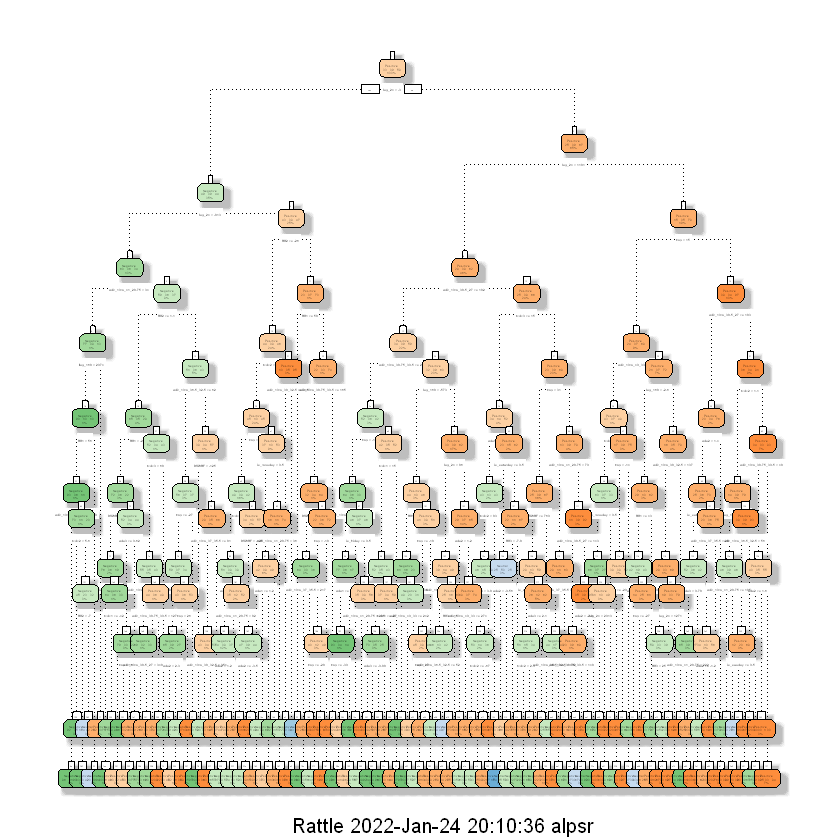

In [111]:
dec_tree2 = rpart(system_direction ~ .,training,method='class',control=rpart.control(cp=0,maxdepth=8))
fancyRpartPlot(dec_tree2)

In [112]:
nodes = data.table(train[,c("date","hour","system_direction")],
                   node=rpart.predict.leaves(dec_tree2,training))
nodes_test = data.table(test[,c("date","hour","system_direction")],
                       node = rpart.predict.leaves(dec_tree2,testing))
nodes[,hour := as.numeric(hour)]
nodes_test[,hour := as.numeric(hour)]

head(nodes_test)

date,hour,system_direction,node
<date>,<dbl>,<chr>,<int>
2021-12-01,1,Negative,60
2021-12-01,2,Neutral,60
2021-12-01,3,Positive,41
2021-12-01,4,Neutral,41
2021-12-01,5,Neutral,51
2021-12-01,6,Positive,60


In [ ]:
training_window = merge(windows,nodes, by = c("date","hour"))
testing_window = merge(windows,nodes_test, by = c("date","hour"))

In [113]:
head(training_window)
head(testing_window)

date,hour,t1,t2,t3,t4,t5,t6,t7,t8,system_direction,node
<date>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
2019-01-08,12,1928.721,1776.793,1824.072,1948.549,2024.501,2276.499,1628.765,1427.524,Positive,141
2019-01-08,13,1776.793,1824.072,1948.549,2024.501,2276.499,1628.765,1427.524,1173.955,Positive,203
2019-01-08,14,1824.072,1948.549,2024.501,2276.499,1628.765,1427.524,1173.955,145.134,Positive,186
2019-01-08,15,1948.549,2024.501,2276.499,1628.765,1427.524,1173.955,145.134,-35.417,Positive,186
2019-01-08,16,2024.501,2276.499,1628.765,1427.524,1173.955,145.134,-35.417,-392.690,Positive,186
2019-01-08,17,2276.499,1628.765,1427.524,1173.955,145.134,-35.417,-392.690,92.241,Positive,203


date,hour,t1,t2,t3,t4,t5,t6,t7,t8,system_direction,node
<date>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
2021-12-01,12,-76.756,-311.200,-768.558,-945.563,-1530.633,-839.498,-432.022,-500.934,Positive,138
2021-12-01,13,-311.200,-768.558,-945.563,-1530.633,-839.498,-432.022,-500.934,-265.800,Negative,60
2021-12-01,14,-768.558,-945.563,-1530.633,-839.498,-432.022,-500.934,-265.800,-260.893,Negative,60
2021-12-01,15,-945.563,-1530.633,-839.498,-432.022,-500.934,-265.800,-260.893,-466.796,Negative,60
2021-12-01,16,-1530.633,-839.498,-432.022,-500.934,-265.800,-260.893,-466.796,-458.977,Negative,60
2021-12-01,17,-839.498,-432.022,-500.934,-265.800,-260.893,-466.796,-458.977,699.439,Positive,100


### k-NN Training

In [114]:
model2 <- train(
    system_direction ~ t1 + t2 + t3 + t4 + t5 + t6 + t7 + t8 + node,
    data = training_window,
    method = "knn",
    trControl = ctrl,
    tuneLength = 5)

In [115]:
model2

k-Nearest Neighbors 

12696 samples
    9 predictor
    3 classes: 'Negative', 'Neutral', 'Positive' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 11427, 11426, 11427, 11427, 11427, 11425, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   5  0.5668457  0.1230520
   7  0.5807873  0.1305218
   9  0.5842532  0.1258439
  11  0.5902918  0.1309286
  13  0.5937573  0.1327221

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 13.

In [116]:
predictions <- predict(model2, testing_window)

In [117]:
table(testing_window$system_direction,predictions)

          predictions
           Negative Neutral Positive
  Negative       10       0       26
  Neutral         1       0        7
  Positive       16       0      108

In [124]:
confusionMatrix(data = as.factor(testing_window$system_direction), reference = as.factor(predictions), mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction Negative Neutral Positive
  Negative       10       0       26
  Neutral         1       0        7
  Positive       16       0      108

Overall Statistics
                                          
               Accuracy : 0.7024          
                 95% CI : (0.6271, 0.7704)
    No Information Rate : 0.8393          
    P-Value [Acc > NIR] : 1.00000         
                                          
                  Kappa : 0.14            
                                          
 Mcnemar's Test P-Value : 0.01559         

Statistics by Class:

                     Class: Negative Class: Neutral Class: Positive
Precision                    0.27778        0.00000          0.8710
Recall                       0.37037             NA          0.7660
F1                           0.31746             NA          0.8151
Prevalence                   0.16071        0.00000          0.8393
Detection Rate               